# UNDERSTANDING ARIMA USING STOCK PRICE PREDICTION

A time series is a sequence of numerical data points in successive order. In investing, a time series tracks the movement of the chosen data points, such as a security’s price, over a specified period of time with data points recorded at regular intervals. There is no minimum or maximum amount of time that must be included, allowing the data to be gathered in a way that provides the information being sought by the investor or analyst examining the activity.

**PROBLEM STATEMENT**<br>
Pick a stock of your choice and forecast the stock price for next 5 business days using historical data.

## DOWNLOAD THE DATA

Let's use Yahoo Finance API to download the stock price of Microsoft. Use `pip install yfinance` to download the yahoo finance package.

You can also use other APIs like Google Finance, IEX, Quandl, AlphaVantage or any other API of your choice.

In [1]:
import yfinance as yf

The ticker for Microsoft is 'MSFT'

In [2]:
msft = yf.Ticker("MSFT")

Let's consider last 6 months of stock data.

In [3]:
df = msft.history(period="60mo")

In [4]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-10-05,41.58,42.61,41.53,42.38,34369300,0.0,0
2015-10-06,42.10,42.88,42.00,42.49,27017200,0.0,0
2015-10-07,42.80,43.03,41.76,42.53,27711500,0.0,0
2015-10-08,42.31,43.19,42.26,43.12,33772700,0.0,0
2015-10-09,43.12,43.20,42.64,42.81,28600600,0.0,0


In [5]:
df.shape

(1259, 7)

In [6]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

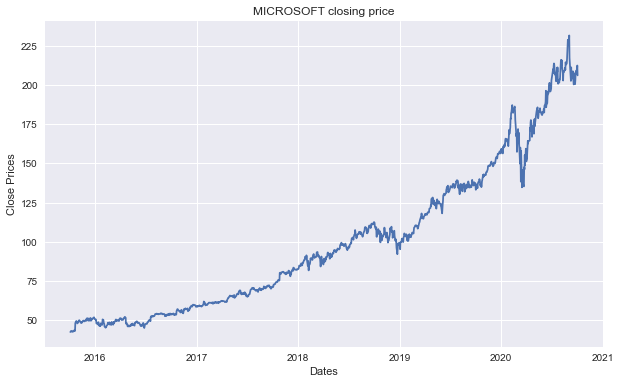

In [7]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('MICROSOFT closing price')
plt.show()

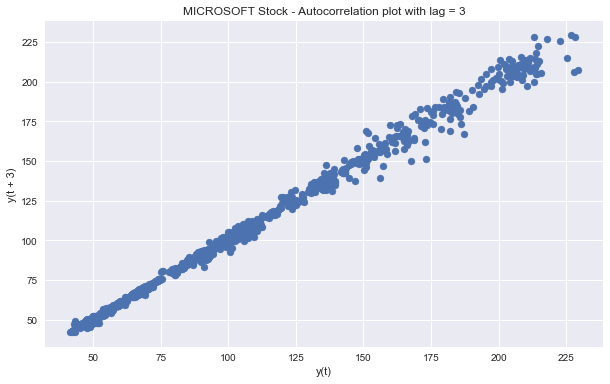

In [8]:
#plot open price
plt.figure(figsize=(10,6))
pd.plotting.lag_plot(df['Open'], lag=3)
plt.title('MICROSOFT Stock - Autocorrelation plot with lag = 3')
plt.show()

## Augmented Dickey-Fuller Test

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

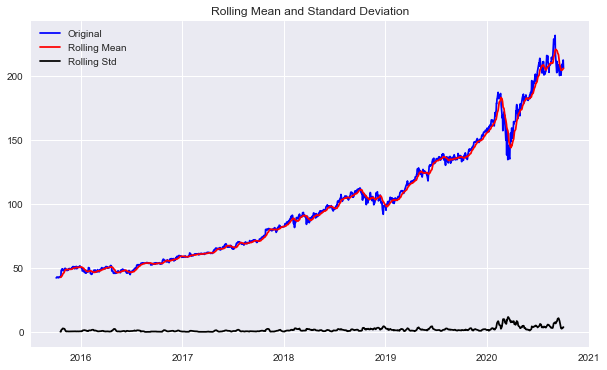

Results of dickey fuller test
Test Statistics                   0.866304
p-value                           0.992634
No. of lags used                  9.000000
Number of observations used    1249.000000
critical value (1%)              -3.435596
critical value (5%)              -2.863857
critical value (10%)             -2.568004
dtype: float64


In [9]:
#Test for staionarity
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')

    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

<Figure size 720x432 with 0 Axes>

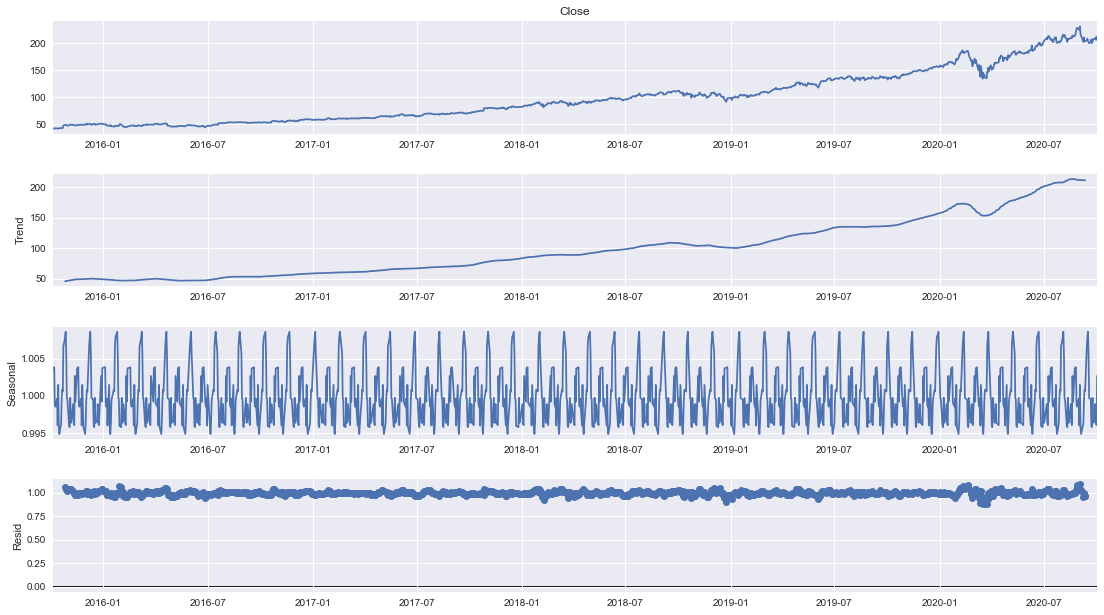

In [10]:
result = seasonal_decompose(df['Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


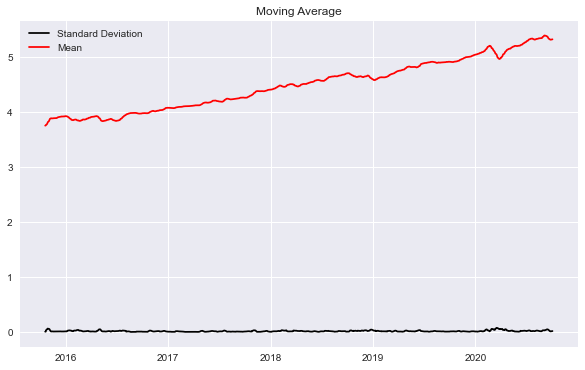

In [11]:
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

## ARIMA

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

In [31]:
#split data into train and training set
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 13.431445473341144


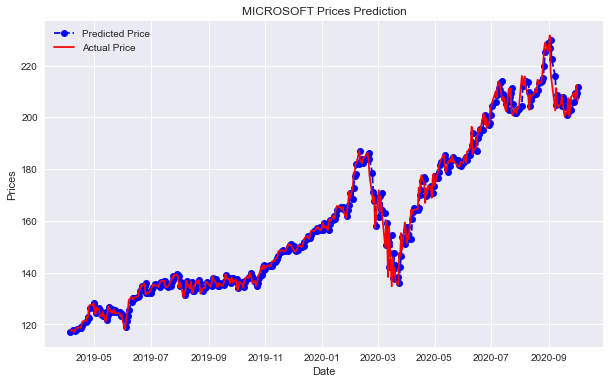

In [13]:
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('MICROSOFT Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

Not bad for training only on less than 1000 data points. 

## AUTO ARIMA

In [15]:
model_autoARIMA = auto_arima(training_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2744.138, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2727.629, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2722.678, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2746.951, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2719.121, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2715.364, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2715.260, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2715.406, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2717.168, Time=1.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2721.462, Time=0.05 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.468 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  881
Model:               SARIMAX(2, 1, 0)   Log Likelihood        

So the Auto ARIMA model provided the value of p,d, and q as 2,1 and 0 respectively.

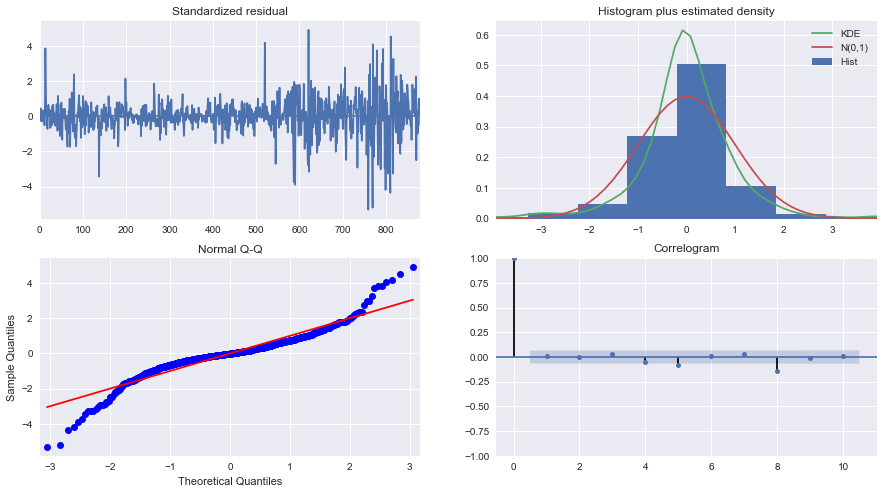

In [17]:
#residual plots from auto ARIMA
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Next, create an ARIMA model with provided optimal parameters p, d and q.

In [37]:
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

/Users/nikhilkashyap/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing Mean Squared Error is 13.233404977479596


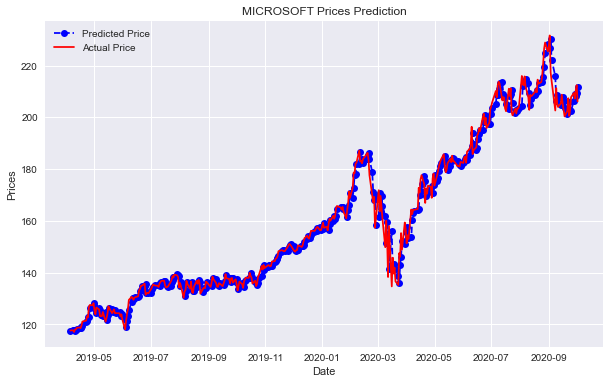

In [39]:
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('MICROSOFT Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()